# Implementation of face recognition using neural net 

In [1]:
%matplotlib inline

In [51]:
import cv2
import numpy as np
import os
from skimage import io
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier


In [3]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

Using TensorFlow backend.


#### Listing the path of all the images

In [4]:
DatasetPath = []
for i in os.listdir("yalefaces"):
    DatasetPath.append(os.path.join("yalefaces", i))

#### Reading each image and assigning respective labels

In [17]:
imageData = []
imageLabels = []

In [18]:
for i in DatasetPath:
    imgRead = io.imread(i,as_grey=True)
    imageData.append(imgRead)
    
    labelRead = int(os.path.split(i)[1].split(".")[0].replace("subject", "")) - 1
    imageLabels.append(labelRead)

#### Preprocessing: Face Detection using OpenCV and cropping the image to a size of 150 * 150

In [19]:
faceDetectClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
imageDataFin = []
for i in imageData:
    facePoints = faceDetectClassifier.detectMultiScale(i)
    x,y = facePoints[0][:2]
    cropped = i[y: y + 150, x: x + 150]
    imageDataFin.append(cropped)

In [20]:
c = np.array(imageDataFin)

In [21]:
c.shape

(165, 150, 150)

#### Splitting Dataset into train and test

In [68]:
X_train, X_test, y_train, y_test = train_test_split(np.array(imageDataFin),np.array(imageLabels), train_size=0.7, random_state = 20)

In [69]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [70]:
X_train.shape

(115, 150, 150)

In [71]:
X_test.shape

(50, 150, 150)

In [72]:
nb_classes = 15
y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [73]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#### Converting each 2d image into 1D vector

In [74]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the data
X_train /= 255
X_test /= 255

#### Preprocessing -PCA

Plot of amount of variance explained vs pcs


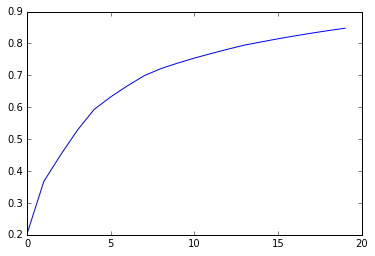

('Training PCA shape', (115, 20))
('Test PCA shape', (50, 20))
Eigen Faces


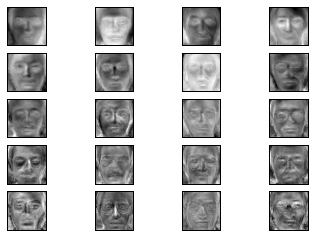

In [81]:
computed_pca = PCA(n_components = 20,whiten=True).fit(X_train)
XTr_pca = computed_pca.transform(X_train)

print("Plot of amount of variance explained vs pcs")
plt.plot(range(len(computed_pca.explained_variance_)),np.cumsum(computed_pca.explained_variance_ratio_))
plt.show()

XTs_pca = computed_pca.transform(X_test)
print("Training PCA shape",XTr_pca.shape)
print("Test PCA shape",XTs_pca.shape)


def plot_eigenfaces(images, h, w, rows=5, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
plot_eigenfaces(computed_pca.components_,150,150)
print("Eigen Faces")

In [57]:
print("Original Training matrix shape", X_train.shape)
print("Original Testing matrix shape", X_test.shape)

('Original Training matrix shape', (115, 22500))
('Original Testing matrix shape', (50, 22500))


In [58]:
print("Fitting the classifier to the training set")
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True).fit(XTr_pca, y_train)

Fitting the classifier to the training set
Iteration 1, loss = 2.68689241
Validation score: 0.083333
Iteration 2, loss = 2.54001110
Validation score: 0.750000
Iteration 3, loss = 2.39617089
Validation score: 0.750000
Iteration 4, loss = 2.25543022
Validation score: 0.833333
Iteration 5, loss = 2.11795828
Validation score: 0.833333
Iteration 6, loss = 1.98390601
Validation score: 0.833333
Iteration 7, loss = 1.85374475
Validation score: 0.916667
Iteration 8, loss = 1.72759504
Validation score: 0.916667
Iteration 9, loss = 1.60570574
Validation score: 0.916667
Iteration 10, loss = 1.48839011
Validation score: 0.916667
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


In [59]:
y_pred = clf.predict(XTs_pca)
#print(y_pred,y_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
          1       1.00      0.80      0.89         5
          2       0.50      1.00      0.67         2
          3       0.60      1.00      0.75         3
          4       1.00      1.00      1.00         5
          5       1.00      0.80      0.89         5
          6       1.00      0.67      0.80         3
          7       0.60      1.00      0.75         3
          8       1.00      0.50      0.67         4
          9       1.00      0.67      0.80         3
         10       1.00      1.00      1.00         4
         11       0.60      1.00      0.75         3
         12       0.67      1.00      0.80         2
         13       1.00      0.50      0.67         4
         14       1.00      0.50      0.67         2

avg / total       0.89      0.82      0.82        50



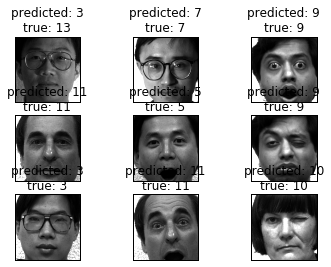

In [37]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=3):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
 
def titles(y_pred, y_test):
    for i in range(y_pred.shape[0]):
        pred_name = y_pred[i]
        true_name = y_test[i]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
 
prediction_titles = list(titles(y_pred, y_test))
plot_gallery(X_test, prediction_titles, 150, 150)


#### Defining the model

In [38]:
model = Sequential()
model.add(Dense(1024,input_shape=(XTr_pca.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# model.add(Dense(75))
# model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              21504     
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                15375     
_________________________________________________________________
activation_2 (Activation)    (None, 15)                0         
Total params: 36,879
Trainable params: 36,879
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

#### Training

In [41]:
model.fit(XTr_pca, Y_train, batch_size=256, epochs=50, verbose=1, validation_data=(XTs_pca, Y_test))

Train on 115 samples, validate on 50 samples
Epoch 1/50
115/115 [==============================] - 0s 4ms/step - loss: 2.7170 - acc: 0.1130 - val_loss: 2.6536 - val_acc: 0.1000
Epoch 2/50
115/115 [==============================] - 0s 206us/step - loss: 2.5745 - acc: 0.2087 - val_loss: 2.5565 - val_acc: 0.2400
Epoch 3/50
115/115 [==============================] - 0s 124us/step - loss: 2.4348 - acc: 0.4522 - val_loss: 2.4610 - val_acc: 0.5200
Epoch 4/50
115/115 [==============================] - 0s 156us/step - loss: 2.3166 - acc: 0.6609 - val_loss: 2.3728 - val_acc: 0.6200
Epoch 5/50
115/115 [==============================] - 0s 167us/step - loss: 2.1863 - acc: 0.8435 - val_loss: 2.2802 - val_acc: 0.6800
Epoch 6/50
115/115 [==============================] - 0s 195us/step - loss: 2.0556 - acc: 0.8783 - val_loss: 2.1892 - val_acc: 0.7200
Epoch 7/50
115/115 [==============================] - 0s 73us/step - loss: 1.9245 - acc: 0.9391 - val_loss: 2.0998 - val_acc: 0.7600
Epoch 8/50
115/115 [

#### Evaluating the performance

In [42]:
loss, accuracy = model.evaluate(XTs_pca,Y_test, verbose=0)

In [43]:
loss

0.52459847927093506

In [44]:
accuracy

0.87999999046325683

In [45]:
predicted_classes = model.predict_classes(XTs_pca)

In [46]:
correct_classified_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_classified_indices = np.nonzero(predicted_classes != y_test)[0]

In [47]:
correct_classified_indices

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18,
       19, 21, 22, 23, 24, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [48]:
incorrect_classified_indices

array([ 0, 11, 20, 25, 28, 32])

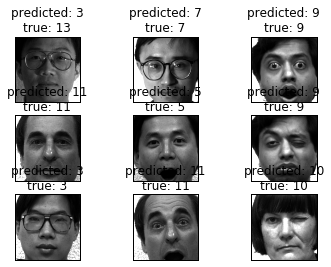

In [50]:
prediction_titles = list(titles(predicted_classes, y_test))
plot_gallery(X_test, prediction_titles, 150, 150)

